# This is the demo for our final projects for cs6955
## homwork by Tao Yang, NIcholas Ledwith, Rui Luo.

In [1]:
import torch
import itertools
import torch.nn as nn
from torch.nn import init
import torchvision
import functools
import torchvision.transforms as T
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import PIL
from PIL import ImageFile
import numpy as np
from scipy.misc import imread
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import ImageFile
import os
import json
ImageFile.LOAD_TRUNCATED_IMAGES = True
from datetime import datetime
import sys
sys.path.append("../")
import sys

sys.path.append("/home/taoyang/research/Tao_lib/")
from Tao_lib.log import Logger
from utils import *
from utils import my_segmentation_transforms
from utils.loss import ls_generator_loss,ls_discriminator_loss
from utils.loss import *
dtype_float=torch.FloatTensor

## Here we show the training data we are going to feed into the cycle_Gan

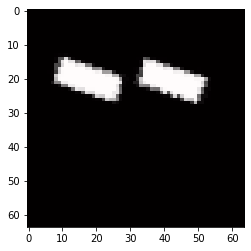

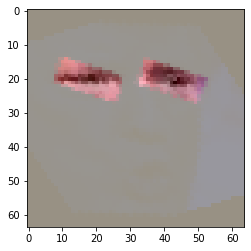

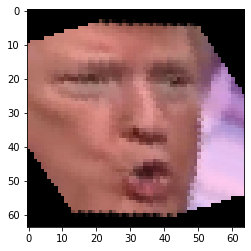

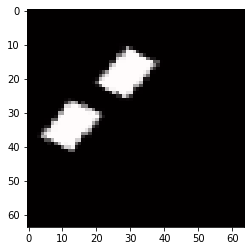

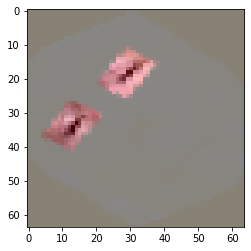

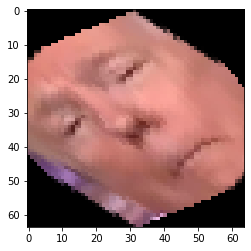

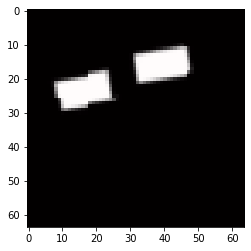

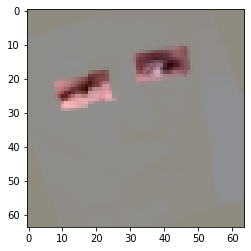

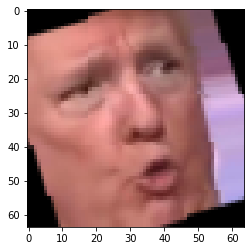

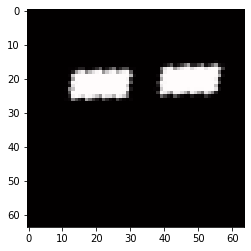

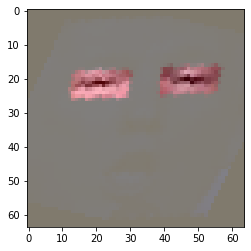

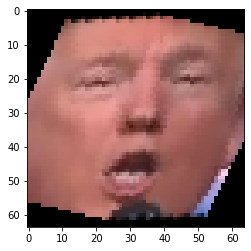

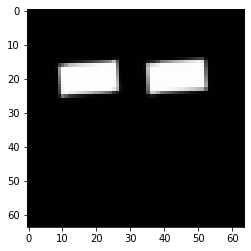

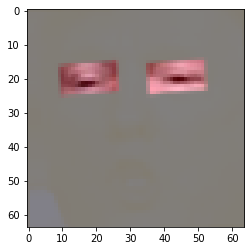

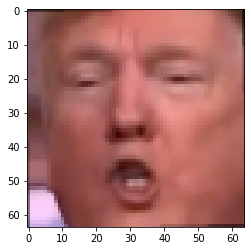

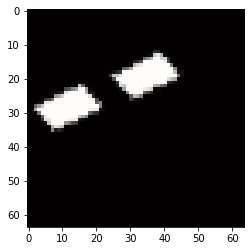

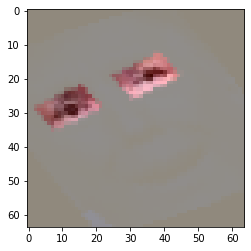

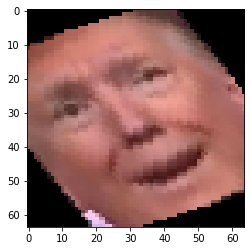

In [2]:
rgb_B="/home/taoyang/research/research_everyday/faceswap-GAN/faceB/rgb/"
mask_B="/home/taoyang/research/research_everyday/faceswap-GAN/faceB/binary_mask/"
data={"size":64}
single=cycle_data_withfolder_mask(rgb_B,mask_B,my_segmentation_transforms,data)
loader_A= DataLoader(single,
                    batch_size=14,
                    num_workers=7,
                    shuffle=True)
for batch_idx, data in enumerate(loader_A):
    if batch_idx>5:
        break     
    plt.figure()

    img1=data["mask"][0,:,:,:].cpu()
    image1=data["rgb"][0,:,:,:].cpu()
    mask=data["mask"]-torch.min(data["mask"])
    img1=deprocess(img1)
    img2=mask[0,:,:,:]*data["rgb"][0,:,:,:]
    img23=img2.numpy()

    plt.imshow(img1)

    plt.show()
    img2_d=deprocess(img2)
    plt.imshow(img2_d)
    plt.show()
    img2_d=deprocess(image1)
    plt.imshow(img2_d)
    plt.show()
    print()  

## Here we show the setting of our code.

In [4]:
data=json.load(open("example/setting.json"))
print(data)

{'GPU': 1, 'batch_size': 16, 'log': '../../logs/', 'size': 64, 'rgb_A': 'data_sets/faceA/rgb/', 'mask_A': 'data_sets/faceA/binary_mask/', 'rgb_B': 'data_sets/faceB/rgb/', 'mask_B': 'data_sets/faceB/binary_mask/', 'rgb_C': 'data_sets/faceB/rgb/', 'shaoanlu': 1, 'fooling_loss_weights': 10, 'discriminator_loss_weight': 1, 'reconstruction_loss_weights': 100, 'cycle_loss_weights': 1, 'edge': 0.0001, 'pl': 0.1, 'maks': 1, 'show_picture': 1, 'show_loss_fig': 0, 'epoch': 100, 'save_iter': 500, 'maxium_iter': 30000}


#  We show some setting of our code, and how to change them.
## We output the intermediate training loss and generated pictures，model archetecture.  More details about the loss and GAN archetecture can be seen in our final reports. You will see that our reconstructed results are gettiing better.

1024
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         294,912
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           8,224
           Conv2d-11           [-1, 32, 16, 16]           8,224
          Softmax-12             [-1, 256, 256]               0
           Conv2d-13          [-1, 256, 16, 16]          65,792
        Self_Attn-14          [-1,

Total params: 102,017
Trainable params: 102,017
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.93
Params size (MB): 0.39
Estimated Total Size (MB): 1.36
----------------------------------------------------------------
{'GPU': 1, 'batch_size': 16, 'log': '../../logs/', 'size': 64, 'rgb_A': 'data_sets/faceA/rgb/', 'mask_A': 'data_sets/faceA/binary_mask/', 'rgb_B': 'data_sets/faceB/rgb/', 'mask_B': 'data_sets/faceB/binary_mask/', 'rgb_C': 'data_sets/faceB/rgb/', 'shaoanlu': False, 'fooling_loss_weights': 10, 'discriminator_loss_weight': 1, 'reconstruction_loss_weights': 100, 'cycle_loss_weights': 1, 'edge': 0.0001, 'pl': 0.1, 'maks': 1, 'show_picture': 1, 'show_loss_fig': 0, 'epoch': 100, 'save_iter': 500, 'maxium_iter': 30000, 'input_nc': 3, 'output_nc': 3, 'ngf': 128, 'norm_layer': <class 'torch.nn.modules.batchnorm.BatchNorm2d'>, 'use_dropout': False, 'n_blocks': 2, 'padding_type': 'refle

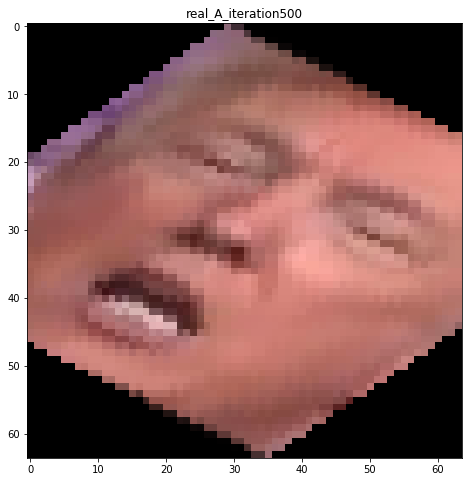

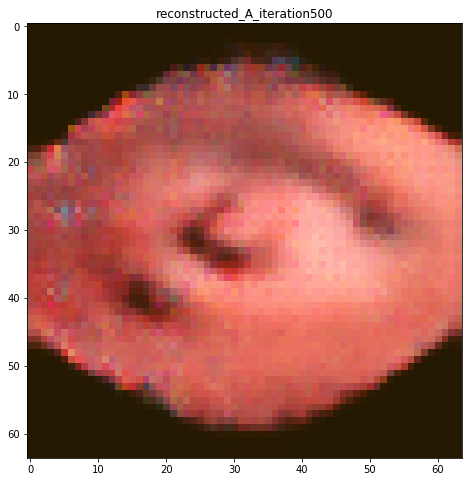

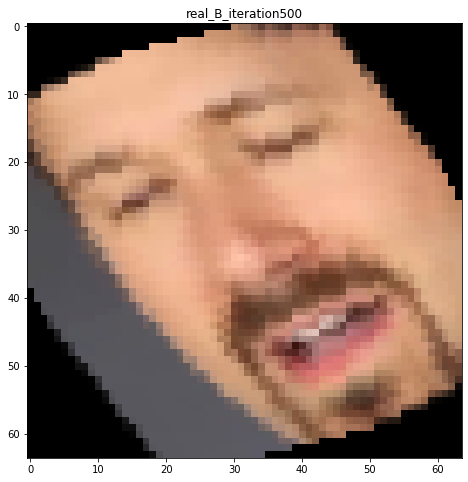

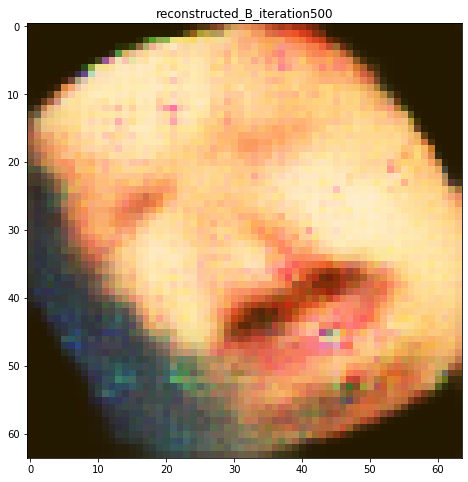

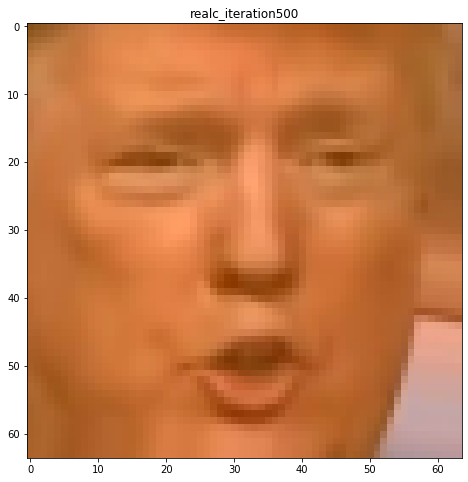

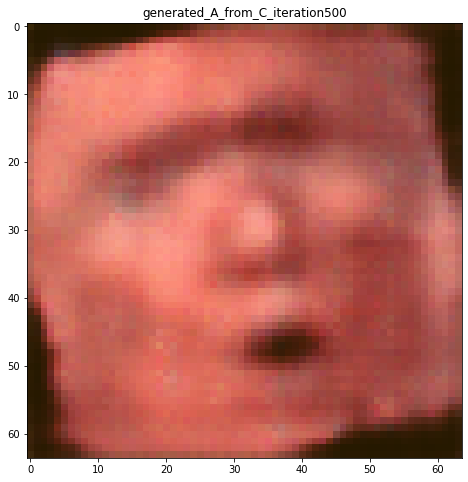

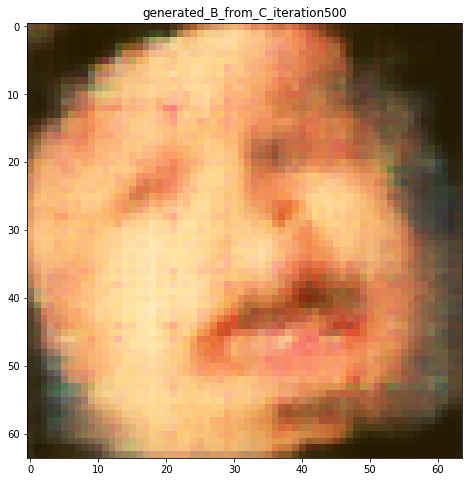

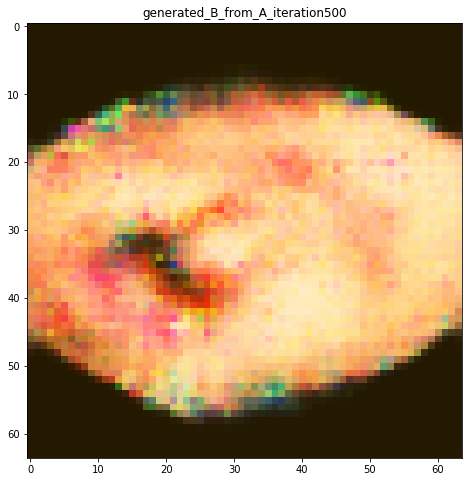

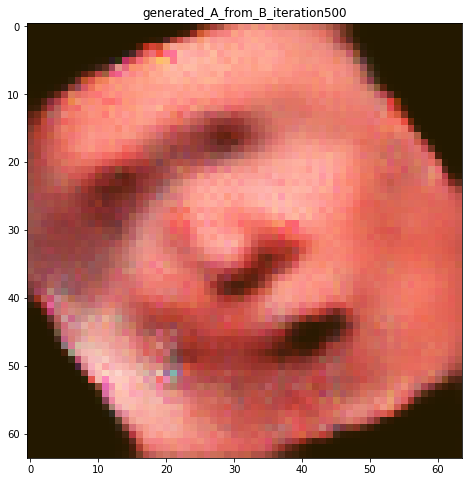

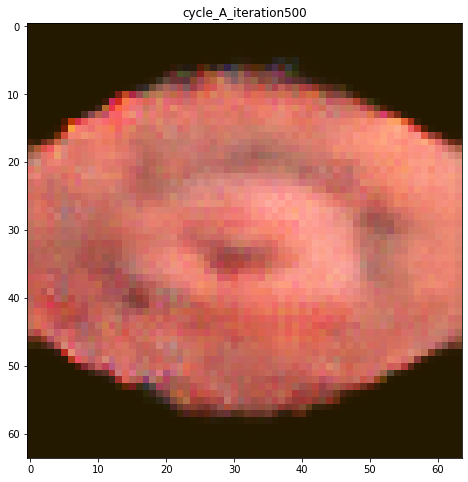

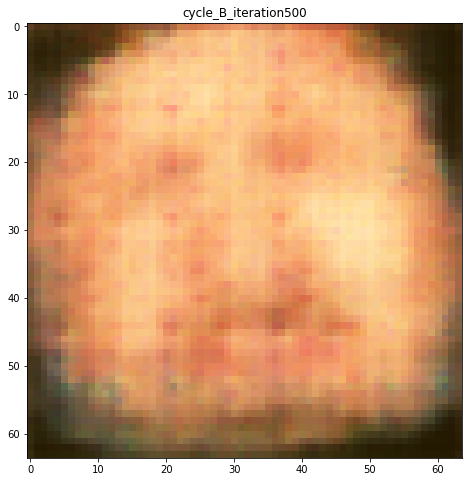

tensor(0.9089, grad_fn=<CopyBackwards>) loss of discriminator
tensor(125.1628, grad_fn=<CopyBackwards>) loss of generator


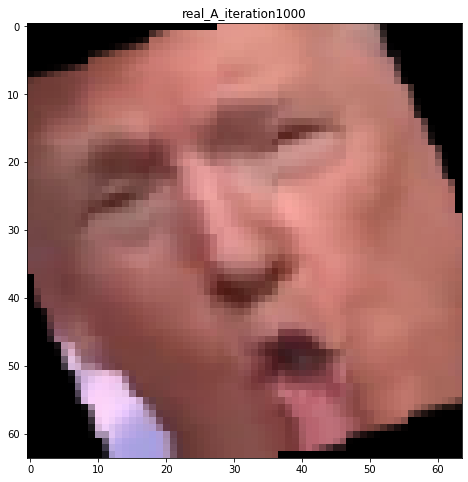

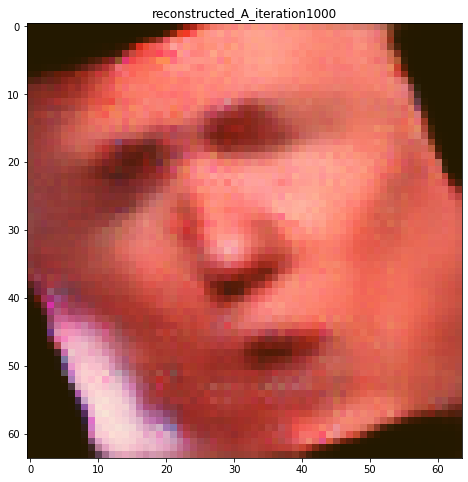

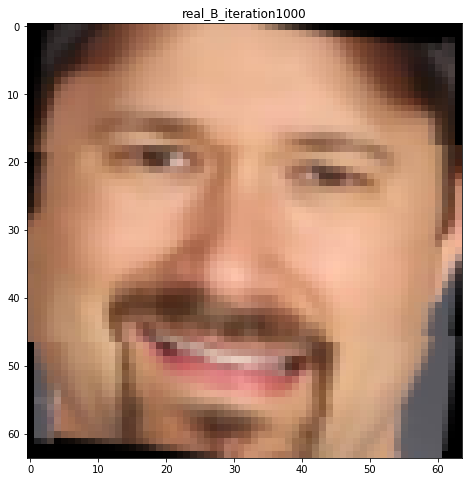

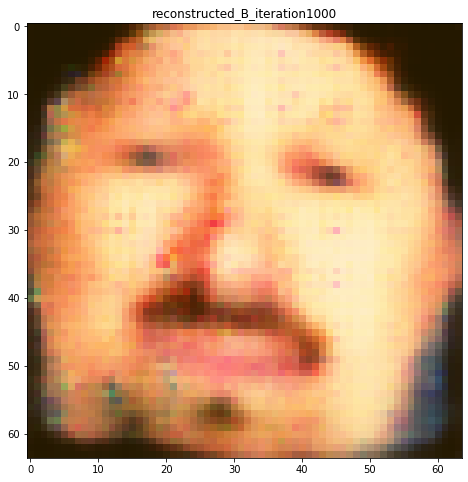

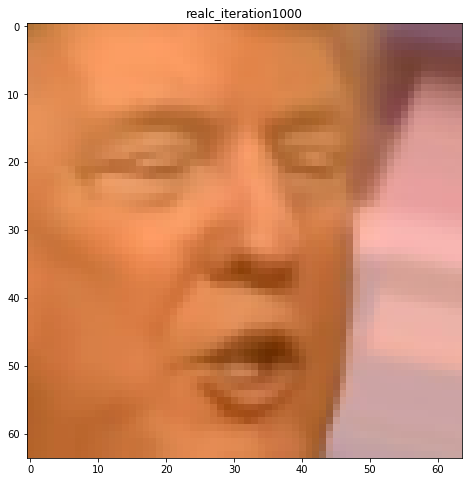

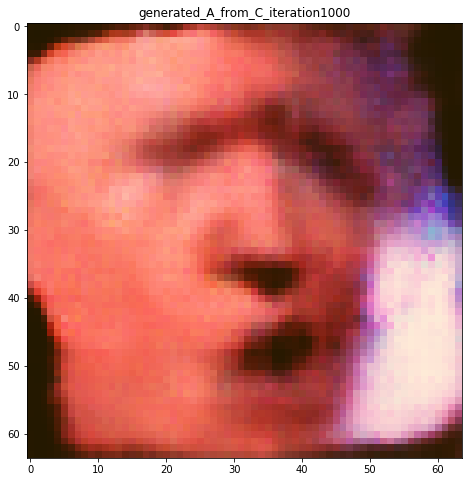

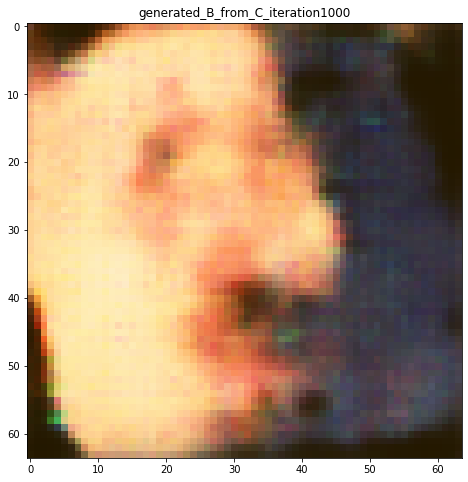

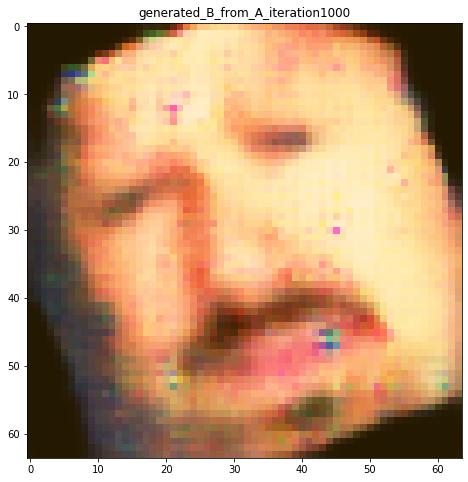

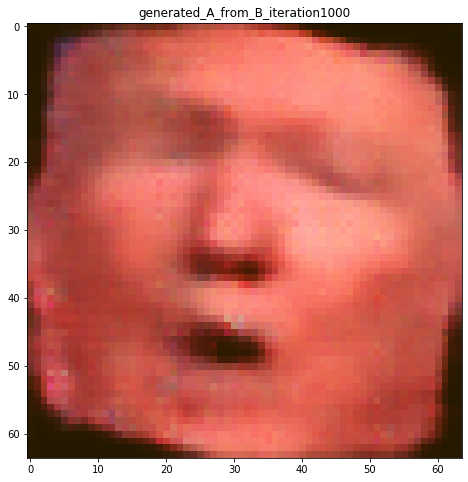

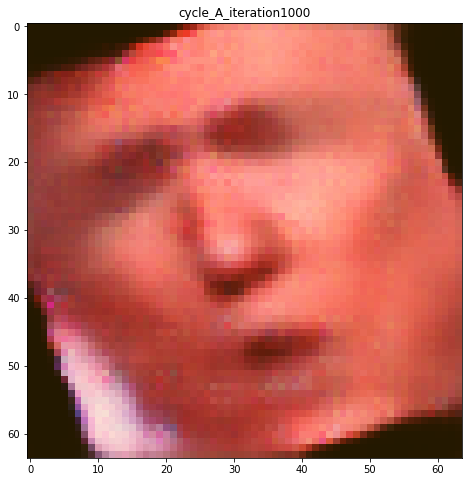

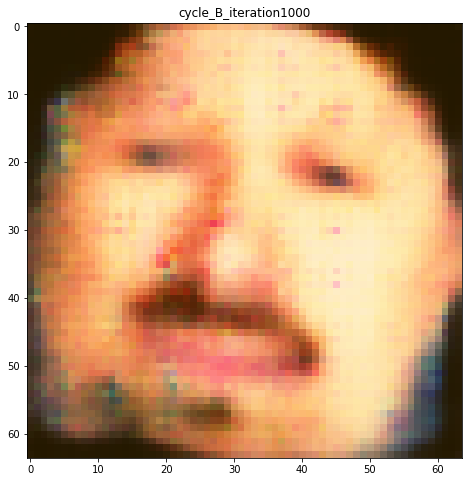

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(data["GPU"])
data.update({"input_nc":3, "output_nc":3, "ngf":128, "norm_layer":nn.BatchNorm2d, "use_dropout":False, "n_blocks":2, "padding_type":'reflect'})

data["type"]=torch.cuda.FloatTensor
data["shaoanlu"]=False
date_a = datetime.now() 
folder_name=str(date_a).replace(" ","-")
log_dir=data["log"]+folder_name
data["ckpt_path"]=log_dir
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
sys.stdout=Logger(log_dir+"/")
G_A,D_A, G_B,D_B,  G_solver, D_solver=cycle_gan(**data)
dtype = torch.cuda.FloatTensor
data["dtype"]=torch.cuda.FloatTensor
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

data_transforms = {
'train': T.Compose([
#     T.RandomResizedCrop(256),
#        T.RandomRotation(10),
#     T.RandomHorizontalFlip(),
   T.Resize((data["size"],data["size"])),
#     T.RandomAffine(10,shear=10),
#     T.ColorJitter(0.2,0.2,0.2),
T.ToTensor()
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': T.Compose([
T.Resize(300),
T.CenterCrop(256),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),}

# monet="/raid/taoyang/research/research_everyday/repository/pytorch-CycleGAN-and-pix2pix/datasets/monet2photo/trainA/"
# photo="/raid/taoyang/research/research_everyday/repository/pytorch-CycleGAN-and-pix2pix/datasets/monet2photo/trainB/"
rgb_A=data["rgb_A"]
rgb_C=data["rgb_C"]
rgb_B=data["rgb_B"]
my_transforms=my_segmentation_transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True

mask_A=data["mask_A"]
mask_B=data["mask_B"]
A=cycle_data_withfolder_mask(rgb_A,mask_A,my_transforms,data)
B=cycle_data_withfolder_mask(rgb_B,mask_B,my_transforms,data)
C_=cycle_data_withfolder(rgb_C,data_transforms["train"])
#     data={"size":64}
#     single=cycle_data_withfolder_mask(A,B,my_segmentation_transforms,data)
loader_A = DataLoader(A,
                    batch_size=data["batch_size"],
                    num_workers=7,
                    shuffle=True)
# loader_content = DataLoader(content,
#                     batch_size=8,
#                     num_workers=7,
#                     shuffle=True)
loader_B= DataLoader(B,
                    batch_size=data["batch_size"],
                    num_workers=7,
                    shuffle=True)
# style=cycle_data('styles/starry_night.jpg',data_transforms["train"])
loader_C = DataLoader(C_,
                    batch_size=data["batch_size"],
                    num_workers=7,
                    shuffle=True)
L1=torch.nn.L1Loss()
L1=torch.nn.L1Loss()
#     data={}

data["A"]=loader_A
data["B"]=loader_B
data["C"]=loader_C
#     date_a = datetime.now() 
#     folder_name=str(date_a).replace(" ","-")
#     log_dir="../../logs/"+folder_name
data["ckpt_path"]=log_dir
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
import sys
sys.path.append("/home/taoyang/research/Tao_lib/")
ls_discriminator_loss=ls_discriminator_loss
ls_generator_loss=ls_generator_loss
loss=run_a_cyclegan(G_A,D_A, G_B,D_B,  G_solver, D_solver, ls_discriminator_loss, ls_generator_loss,data=data, num_epochs=50)

In [14]:
print(loss)
gen_loss=loss['generator']
dis_loss=loss['discriminator']
iteration=loss['iteration']
plt.figure()
plt.plot(iteration,gen_loss)
plt.show()
plt.figure()
plt.plot(iteration,dis_loss)
plt.show()

TypeError: 'NoneType' object is not subscriptable

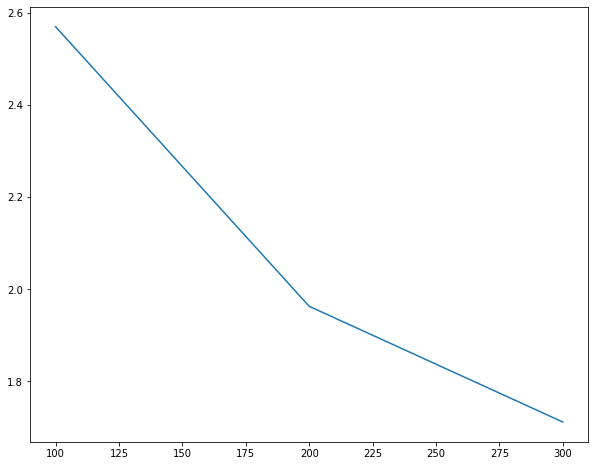